### Exercise 3

Consider the following setting: The input space is $\mathcal{X} = [0, 1]$ and the output space is $\mathcal{Y} = \{0, 1\}$. The input data $x \in \mathcal{X}$ is uniformly distributed. The Bayes classifier

$$
f^*(x)=\begin{cases}
1 & x \in [0.2, 0.8]\\
0 & \text{otherwise}
\end{cases}.
$$

has zero Bayes risk $R^*=R(f^*) = 0$. We consider two hypotheses classes. The first hypothesis class 

$$
\mathcal{H}_{T} = \big\{f_{\theta}\,:\, \theta\in [0, 1]\big\}
$$

consists of threshold functions of the form

$$
f_{\theta}(x) = \begin{cases}
0 & x < \theta\\
1 & x \geq \theta
\end{cases}.
$$

The second hypothesis class 

$$
\mathcal{H}_{I} = \big\{f_{a, b}\,:\, 0 \leq a \leq b\leq 1\big\}
$$

consists of interval functions of the form

$$
f_{a, b}(x) = \begin{cases}
1 & a \leq x \leq b\\
0 & \text{otherwise}
\end{cases}.
$$


**(a)** Implement ERM learners for both hypothesis classes. 


**(b)** Consider the following experiment for a given learner $A$ (see Exercise 2 of Assignment 4b): 

1. Sample a training set $\mathcal{S}$ of size $n$. 
2. Fit a model $A(\mathcal{S}) = f_n$
3. Compute the empirical risk $R_n(f_n)$
4. Compute the true risk $R(f_n)$
5. Estimate the probability $\mathbb{P}(|R_n(f_n) - R(f_n)|\geq \varepsilon)$ for $\varepsilon=0.1$

Repeat the experiment $T$ times for different sizes $n$ and for the ERM learner w.r.t. both hypothesis classes. 

Plot the VC inequalities, the probabilities $\mathbb{P}(|R_n(f_n) - R(f_n)|\geq \varepsilon)$, the average empirical risk $R_n(f_n)$ and the true risk $R(f)$ as functions of the sample size $n$. Use different figure or axes objects to obtain clear and readable plots. Compare the results obtained by ERM w.r.t. both hypothesis classes.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.special import comb

### Constants

In [2]:
# Interval of positive class
LOWER = 0.2
UPPER = 0.8

### Sampling

In [3]:
def sample(n):
    X = np.random.random(n)
    y = ((LOWER <= X) & (X <= UPPER)).astype(int)
    return X, y

### Classifiers

In [4]:
class ThresholdClassifier:
    
    def true_risk(self):
        if self.theta < LOWER:
            return (LOWER - self.theta) + (1. - UPPER)
        elif self.theta <= UPPER:
            return (self.theta - LOWER) + (1. - UPPER)
        else:
            return (UPPER - LOWER) + (1. - self.theta)
        
    def empirical_risk(self, X, y):
        y_pred = (X >= self.theta).astype(int)
        return 1. - accuracy_score(y, y_pred)

    def fit(self, X, y):
        self.theta = 1
        Z = X[y==1]
        if len(Z):
            self.theta = Z.min()
    
    def growth(self, n):
        return n+1
    

class IntervalClassifier:
    
    def true_risk(self):
        a, b = min(1, max(0, self.a)), min(1, max(0, self.b))
        if b < a: a, b = b, a

        if b < LOWER or a > UPPER:
            return UPPER - LOWER + b - a
        else:
            return abs(LOWER - a) + abs(UPPER - b) 

    def empirical_risk(self, X, y):
        y_pred = ((self.a <= X) & (X <= self.b)).astype(int)
        return 1. - accuracy_score(y, y_pred)

    def fit(self, X, y):
        self.a, self.b = -1, -1
        Z = X[y==1]
        if len(Z):
            self.a = Z.min()
            self.b = Z.max()
    
    def growth(self, n):
        return comb(n+1, 2)+1

---
### Auxiliary Functions

In [5]:
def run(f, n_samples, n_runs=100, eps=0.1):
    k = len(n_samples)
    R = np.zeros((k, n_runs))
    Rn = np.zeros((k, n_runs))
    P = np.zeros(k)
    for i, n in enumerate(n_samples):
        for j in range(n_runs):
            X, y = sample(n)
            f.fit(X, y)
            Rn[i,j] = f.empirical_risk(X, y)
            R[i,j] = f.true_risk()
    P = np.mean(np.abs(Rn-R) >= eps, axis=1)
    # VC inequality
    H = f.growth(2*n_samples)
    B = 4.*H*np.exp(-2.*n_samples*eps**2)
    return Rn, R, P, B


---
### Experiments

In [6]:
n_samples=np.arange(10, 301, 10)
n_runs = 1000
eps = 0.1

In [7]:
f1 = ThresholdClassifier()
Rn1, R1, P1, B1 = run(f1, n_samples, n_runs, eps)

In [8]:
f2 = IntervalClassifier()
Rn2, R2, P2, B2 = run(f2, n_samples, n_runs, eps)

---
### VC Inequality

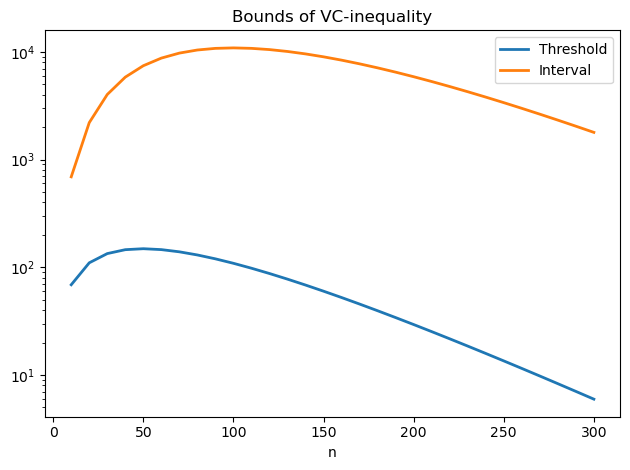

In [9]:
plt.semilogy(n_samples, B1, lw=2, label='Threshold')
plt.semilogy(n_samples, B2, lw=2, label='Interval')
plt.xlabel('n')
plt.title('Bounds of VC-inequality')
plt.legend()
plt.tight_layout()
plt.show()

---
### Probabilities

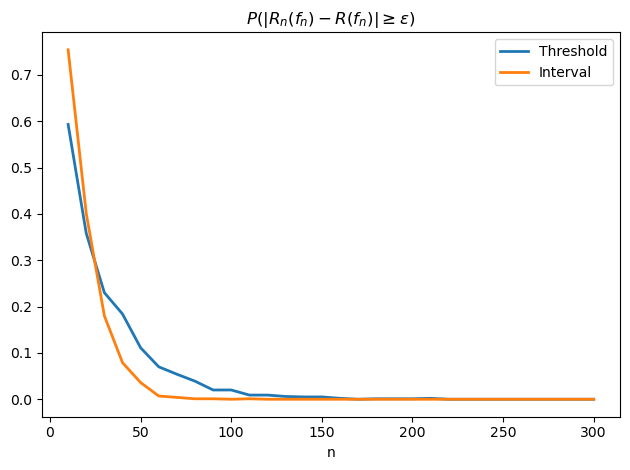

In [10]:
plt.plot(n_samples, P1, lw=2,
             label='Threshold')
plt.plot(n_samples, P2, lw=2, 
             label='Interval')
plt.xlabel('n')
plt.title('$P(|R_n(f_n)-R(f_n)|\geq \epsilon)$')
plt.legend()
plt.tight_layout()
plt.show()

---
### Empirical and True Risk

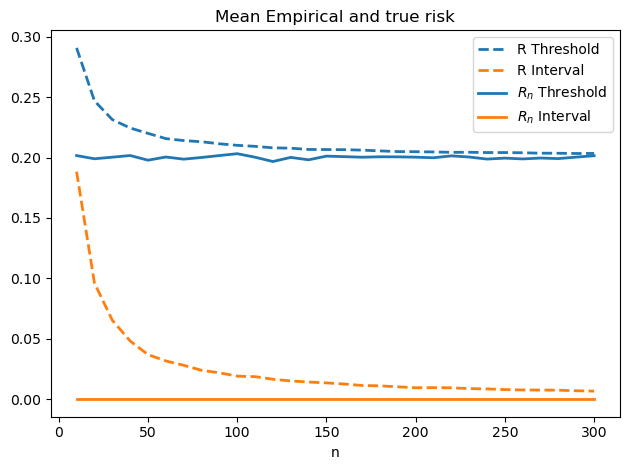

In [12]:
plt.plot(n_samples, R1.mean(axis=1), lw=2, linestyle='--', 
         color='tab:blue', label='R Threshold')
plt.plot(n_samples, R2.mean(axis=1), lw=2, linestyle='--', 
         color='tab:orange', label='R Interval')
plt.plot(n_samples, Rn1.mean(axis=1), lw=2, 
         color='tab:blue', label='$R_n$ Threshold')
plt.plot(n_samples, Rn2.mean(axis=1), lw=2, 
         color='tab:orange', label='$R_n$ Interval')
plt.xlabel('n')
plt.title('Mean Empirical and true risk')
plt.legend()
plt.tight_layout()
plt.show()